In [1]:
import csv
import cv2
import pytesseract 
from pytesseract import image_to_string
import pandas as pd
import re
import os
import numpy as np
from moviepy.video.io.VideoFileClip import VideoFileClip
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
pytesseract.pytesseract.tesseract_cmd = r'C:\ProgramData\anaconda3\Library\bin\tesseract.exe'

In [37]:
def extract_text(roi):
   
    gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    # Apply thresholding to the grayscale image
    threshold = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]    
   
    # Get the text from the thresholded image using Tesseract OCR
    text = pytesseract.image_to_string(threshold)
    return text
    

In [38]:
def extract_text_grayscale(roi):
   
    
    threshold = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]    
    text = pytesseract.image_to_string(image, config=tessdata_dir_config)
    
    return text
    

In [39]:
def extract_numbers(roi):
   
    gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    threshold = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]    
    text = pytesseract.image_to_string(threshold, lang='digits')
    
    return text
    

In [40]:
def extract_number_grayscale(roi):
   
    
    threshold = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]    
   
    # Get the text from the thresholded image using Tesseract OCR
    text = pytesseract.image_to_string(threshold, lang='digits')
    return text
    

In [41]:
def extract_frame(img_rgb,template):
    
    desired_width = 1625
    desired_height = 911
    img_rgb = cv2.resize(img_rgb, (desired_width,desired_height))
    
    assert img_rgb is not None, "file could not be read, check with os.path.exists()"
    img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
    #plt.imshow(cv.cvtColor(template, cv.COLOR_BGR2RGB))
    
    assert template is not None, "file could not be read, check with os.path.exists()"
    w, h = template.shape[::-1]
    res = cv2.matchTemplate(img_gray,template,cv2.TM_CCOEFF_NORMED)
    threshold = 0.4
    loc = np.where( res >= threshold)
    #for pt in zip(*loc[::-1]):
     #cv2.rectangle(img_rgb, pt, (pt[0] + w, pt[1] + h), (0,0,255), 2)
    
    cropped_image=img_rgb.copy()
    
    for pt in zip(*loc[::-1]):
        x, y = pt
        w, h = template.shape[::-1]
        # Crop the matched region
        cropped_image = img_rgb[y:y+h, x:x+w]

        # Save the cropped image
        #cv.imwrite('cropped_image.jpg', cropped_image)

        # Draw a rectangle around the matched region
        #cv.rectangle(img_rgb, pt, (x + w, y + h), (0, 0, 255), 2)
    
    cropped_image=cv2.resize(cropped_image,(template.shape[1],template.shape[0]) )
    return cropped_image

In [42]:
def get_country(frame):
       
    roi = frame[0:60,40:105]
        
    #plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))   
    return extract_text(roi)   
    

In [43]:
def get_name(frame):
       
    roi = frame[0:60,210:600]
    #plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))  
        
    return extract_text(roi)

In [44]:
def extract_somersaults(text):
    match1 = re.search(r'\d+% SOMERSAULTS', text,re.IGNORECASE)
    if match1:
        somersaults = float(match1.group(0).split('%')[0])+0.5
        return somersaults
    match2 = re.search(r'(\d+(\.\d+)?)\D*\b(somersaults?)\b', text, re.IGNORECASE)
    if match2:
        somersaults = match2.group(1)
        return somersaults


In [45]:
def extract_twists(text):
    match1 = re.search(r'\d+% TWISTS', text,re.IGNORECASE)
    if match1:
        twists = float(match1.group(0).split('%')[0])+0.5
        return twists
    match2 = re.search(r'(\d+(\.\d+)?)\D*\b(twists?)\b', text, re.IGNORECASE)
    if match2:
        twists = match2.group(1)
        return twists

In [46]:
def extract_allothers(text): 
    difficulty=""
    round=""
    divePosition=""
    diveGroup=""
    
    match = re.search(r'DIFFICULTY (\d+(\.\d+)?)', text, re.IGNORECASE)
    if match:
        difficulty = match.group(1)
    match = re.search(r'ROUND (\d+)', text, re.IGNORECASE)
    if match:
        round = match.group(1)        
    match = re.search(r'(\w+) POSITION', text,re.IGNORECASE)
    if match:
        divePosition = match.group(1) 
    match = re.search(r'(ARMSTAND|BACK|INWARD|FORWARD|REVERSE|TWISTER|ARMSTAND BACK|ARMSTAND FORWARD|BACK ARMSTAND|BACK FORWARD|BACK INWARD|BACK REVERSE|BACK TWISTER|FORWARD ARMSTAND|FORWARD BACK|FORWARD INWARD|FORWARD REVERSE|FORWARD TWISTER|INWARD BACK|INWARD FORWARD|INWARD REVERSE|INWARD TWISTER|REVERSE BACK|REVERSE FORWARD|REVERSE INWARD|REVERSE TWISTER|TWISTER BACK|TWISTER FORWARD|TWISTER INWARD|TWISTER REVERSE)', text, re.IGNORECASE)
    if match:
        diveGroup = match.group(1)
    
    return difficulty,round,divePosition,diveGroup

    

In [47]:
def extract_diveinfo(frame):
    country=""
    firstName=""
    secondName=""
    difficulty = ""
    round = ""
    diveGroup=""
    divePosition=""
    somersaults=""
    twists=""
    
    country =""
    name=""
    
    text = extract_text(frame)
    country=get_country(frame)
    name=get_name(frame)
    difficulty,round,divePosition,diveGroup=extract_allothers(text)
    somersaults = extract_somersaults(text)
    twists = extract_twists(text)  
                
    
    return round,country,name,difficulty,divePosition,somersaults,diveGroup,twists



In [48]:
def skel(img):
    size = np.size(img)
    skel = np.zeros(img.shape,np.uint8)

    ret,img = cv2.threshold(img,127,255,0)
    element = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))
    done = False

    while( not done):
        eroded = cv2.erode(img,element)
        temp = cv2.dilate(eroded,element)
        temp = cv2.subtract(img,temp)
        skel = cv2.bitwise_or(skel,temp)
        img = eroded.copy()

        zeros = size - cv2.countNonZero(img)
        if zeros==size:
            done = True
    return skel

In [114]:
def get_final_score(frame,text):
    score=""
    match = re.search(r'SCORE (\d+)', text, re.IGNORECASE)
    if match:
        score = match.group(1)  
        return score
    
    roi = frame[50:100,910:1100]
    plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))  
        
    return extract_numbers(roi)


72.00



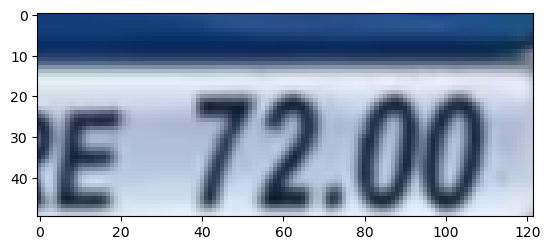

In [113]:
#score_frame = cv2.imread('HelperImages/mainRioRes.png')  
#template=cv2.imread('HelperImages/template_res_london.png',cv2.IMREAD_GRAYSCALE) 
#cropped=extract_frame(score_frame,template)
#print(get_final_score(cropped))
    


In [116]:
def extract_penalty(text):       
    penalty = ""
    judgesScore=""
    match = re.search(r'PENALTY (\d+)', text, re.IGNORECASE)
    if match:
        penalty = match.group(1)    
    return penalty

def get_score(frame):
    #plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    penalty="0"
    text=extract_text(frame)
    match = re.search(r'PENALTY (\d+)', text, re.IGNORECASE)
    if match:
        penalty = match.group(1)
        
    roi = frame[110:155,5:1150]
    plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
    roi_new=remove_strikes(roi) 
    text=extract_number_grayscale(roi_new)
    numbers = re.findall(r'\d+\.\d+|\d+', text)

    # Convert the extracted numbers to floating-point values
    numbers = [float(number) for number in numbers]
    return numbers,penalty 
    
    

In [207]:
def remove_strikes(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, image = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 1))
    eroded_image = cv2.erode(image, kernel, iterations=5)
    result = image-eroded_image 
    
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 1))
    result =cv2.morphologyEx(result, cv2.MORPH_CLOSE, kernel, iterations=1)
    
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 1))
    result=cv2.erode(result,kernel,iterations=2)
    
    result = skel(result)
    
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2,3))
    result=cv2.dilate(result,kernel,iterations=2)
    
    
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 1))
    eroded_image = cv2.erode(result, kernel, iterations=5)    
    
    return result



In [107]:
def extract_clip(input_video_path, output_video_path, start_time, end_time):
    print(input_video_path)
    print(output_video_path)
    print(start_time)
    print(end_time)
    # Create a VideoFileClip object for the input video
    video_clip = VideoFileClip(input_video_path)

    # Extract the subclip between start_time and end_time
    clip = video_clip.subclip(start_time, end_time)

    # Write the clip to the output video file
    clip.write_videofile(output_video_path)

    # Close the VideoFileClip object
    video_clip.close()